# Classify text with BERT



1. Load the
 dataset
2. Load a BERT model from TensorFlow Hub
3. Build your own model by combining BERT with a classifier
4. Train your own model, fine-tuning BERT as part of that
5. Save your model and use it to classify sentences


The below cell outputs are for the IMDB Dataset

## Setup


In [ ]:
!pip install ipython-autotime
!pip install -q -U tensorflow-text
!pip install -q tf-models-official

%load_ext autotime

     |████████████████████████████████| 4.9 MB 4.3 MB/s 
     |████████████████████████████████| 1.8 MB 5.4 MB/s 
     |████████████████████████████████| 47.6 MB 36 kB/s 
     |████████████████████████████████| 1.2 MB 37.2 MB/s 
     |████████████████████████████████| 596 kB 31.1 MB/s 
     |████████████████████████████████| 99 kB 8.4 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 1.1 MB 33.6 MB/s 
     |████████████████████████████████| 90 kB 7.9 MB/s 
     |████████████████████████████████| 213 kB 51.0 MB/s 
     |████████████████████████████████| 352 kB 48.9 MB/s 
time: 1.7 ms (started: 2021-11-14 15:53:20 +00:00)


In [ ]:
# import packages
import os
import shutil
import re
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization 

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

time: 2.92 s (started: 2021-11-14 15:53:32 +00:00)


### IMDB dataset



In [ ]:
# download the dataset
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84140032/84125825 [==============================] - 2s 0us/step
time: 37.7 s (started: 2021-11-14 15:54:05 +00:00)


In [ ]:
# load the dataset
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
time: 10.1 s (started: 2021-11-14 15:55:13 +00:00)


### Twitter Dataset

In [ ]:
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', encoding='latin-1', header = None)

In [ ]:
df.columns=['Sentiment', 'id', 'Date', 'Query', 'User', 'Tweet']
df = df.drop(columns=['id', 'Date', 'Query', 'User'], axis=1)
df['Sentiment'] = df.Sentiment.replace(4,1)

import re

hashtags = re.compile(r"^#\S+|\s#\S+")
mentions = re.compile(r"^@\S+|\s@\S+")
urls = re.compile(r"https?://\S+")

def process_text(text):
    text = re.sub(r'http\S+', '', text)
    text = hashtags.sub(' hashtag', text)
    text = mentions.sub(' entity', text)
    return text.strip().lower()

df['Tweet'] = df.Tweet.apply(process_text)
labels = df.Sentiment.values
text = df.Tweet.values

In [ ]:
X, Y = list(df["Tweet"]), list(df["Sentiment"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10)

### Define the model

In [ ]:
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
# small BERT Model
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1'
# BERT Base model
# tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'


time: 2.08 ms (started: 2021-11-14 15:57:15 +00:00)


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

time: 7.86 ms (started: 2021-11-14 16:00:10 +00:00)


### Load and train the BERT model

In [ ]:
classifier_model = build_classifier_model()
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [ ]:
# loss function
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

no_epochs = 3
steps_per_epoch = 625
num_train_steps = steps_per_epoch * no_epochs
num_warmup_steps = int(0.1*num_train_steps)
init_lr = 3e-5

# optimiser
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

time: 22.4 ms (started: 2021-11-14 16:02:35 +00:00)


In [ ]:
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=no_epochs)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


625/625 [==============================] - 220s 341ms/step - loss: 0.5048 - binary_accuracy: 0.7411 - val_loss: 0.4134 - val_binary_accuracy: 0.8168
Epoch 2/3
625/625 [==============================] - 205s 327ms/step - loss: 0.3691 - binary_accuracy: 0.8378 - val_loss: 0.3919 - val_binary_accuracy: 0.8316
Epoch 3/3
625/625 [==============================] - 204s 326ms/step - loss: 0.3192 - binary_accuracy: 0.8626 - val_loss: 0.4080 - val_binary_accuracy: 0.8328
time: 11min 14s (started: 2021-11-14 16:02:36 +00:00)


### Evaluate the model


In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 148s 189ms/step - loss: 0.3897 - binary_accuracy: 0.8364
Loss: 0.3896528482437134
Accuracy: 0.8364400267601013
time: 2min 28s (started: 2021-11-14 16:25:11 +00:00)


### Plot accuracy and loss


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


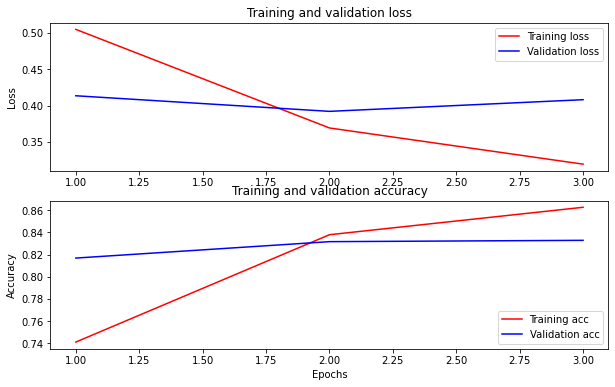

time: 539 ms (started: 2021-11-14 16:27:40 +00:00)


In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')